# Evaluate mock community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of mock communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment/")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

In [4]:
dataset_ids = ['mock-' + str(m) for m in (3, 12, 18, 22, 24, '26-ITS1', '26-ITS9')]

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods to add, set `append=True`. If you are attempting to recompute pre-computed results, set `force=True`.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [16]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                method_ids=['naive-bayes'],
                                append=True,
                                force=False)

/Users/nbokulich/Desktop/projects/short-read-tax-assignment/data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True
append==True and force==False
0 new results have been appended to results.


In [17]:
mock_results['Reference'].unique()

array(['gg_13_8_otus_amplicon', 'unite_20.11.2016_clean_read',
       'gg_13_8_otus_read', 'unite_20.11.2016_clean_amplicon'], dtype=object)

Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons. This can be performed as shown below — alternatively, specific reference databases, datasets, methods, or parameters can be chosen by setting dataset_ids, reference_ids, method_ids, and parameter_ids in the evaluate_results command above.

In [12]:
mock_results = filter_df(mock_results, column_name='Reference',
                         values=['gg_13_8_otus_amplicon', 'gg_13_8_otus_read'
                                   'unite_20.11.2016_clean_amplicon',
                                   'unite_20.11.2016_clean_read'], exclude=False)

Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. **Higher scores = better accuracy**

As a first step, we will evaluate **average** method performance at each taxonomic level for each method within each reference dataset type.

**Note that, as parameter configurations can cause results to vary widely, average results are not a good representation of the "best" results. See [here](#Optimized-method-performance) for results using optimized parameters for each method.**

First we will define our [color palette](http://matplotlib.org/examples/color/named_colors.html) and the variables we want to plot. Via seaborn, we can apply the [xkcd crowdsourced color names](https://xkcd.com/color/rgb.txt). If that still doesn't match your hue, use hex codes.

In [18]:
color_pallette={
    'naive-bayes': 'black'
}

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

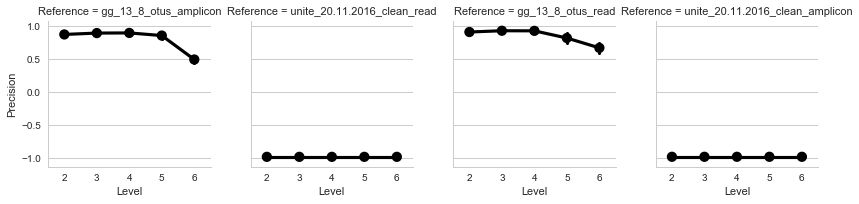

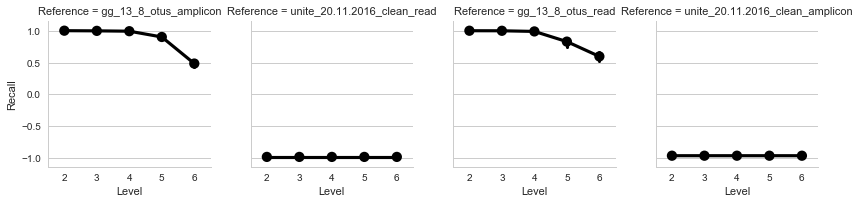

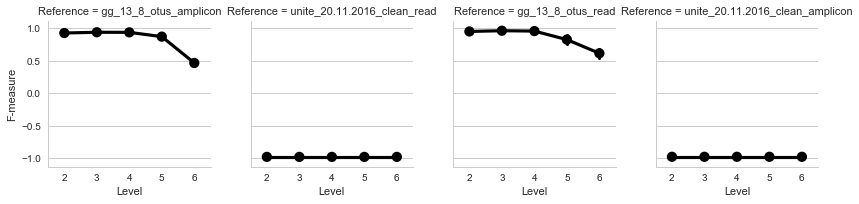

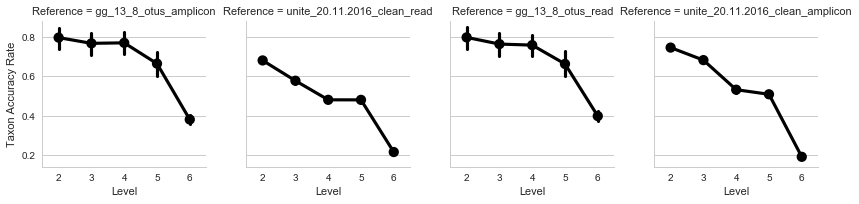

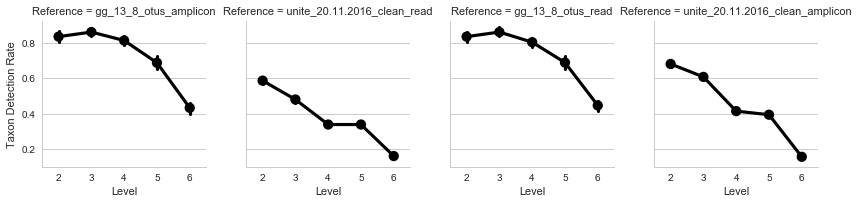

In [19]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [172]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Reference              Variable              2  \
0                    gg_13_8_otus             Precision   1.077059e-02   
1                    gg_13_8_otus                Recall   6.293206e-28   
2                    gg_13_8_otus             F-measure   2.320716e-01   
3                    gg_13_8_otus   Taxon Accuracy Rate   6.959912e-06   
4                    gg_13_8_otus  Taxon Detection Rate   9.584542e-01   
5  unite_20.11.2016_clean_fullITS             Precision   4.601516e-28   
6  unite_20.11.2016_clean_fullITS                Recall   0.000000e+00   
7  unite_20.11.2016_clean_fullITS             F-measure   2.173682e-55   
8  unite_20.11.2016_clean_fullITS   Taxon Accuracy Rate  4.384513e-265   
9  unite_20.11.2016_clean_fullITS  Taxon Detection Rate  2.337681e-127   

               3              4              5              6  
0   9.455196e-02   2.558814e-01   1.905525e-03   1.022860e-02  
1   9.844389e-15   7.991753e-23   1.486565e-17   4.265048e-05  
2   5.350801e-01   9.777715e-01   1.336838e-06   1.905525e-03  
3   8.134356e-02   5.010372e-03   2.476416e-23   7.578604e-16  
4   8.763574e-01   5.649290e-07   5.948615e-47   4.774055e-32  
5   1.930879e-29   1.067839e-30   7.536402e-53  1.084495e-132  
6   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00  
7   2.073542e-69   5.405091e-54   2.663020e-66  7.336023e-112  
8  2.122026e-308  4.685986e-305  9.104506e-280   0.000000e+00  
9  2.204186e-218  4.205315e-228  2.371274e-235   0.000000e+00

### Heatmaps of per-level accuracy
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal mock communities individually).

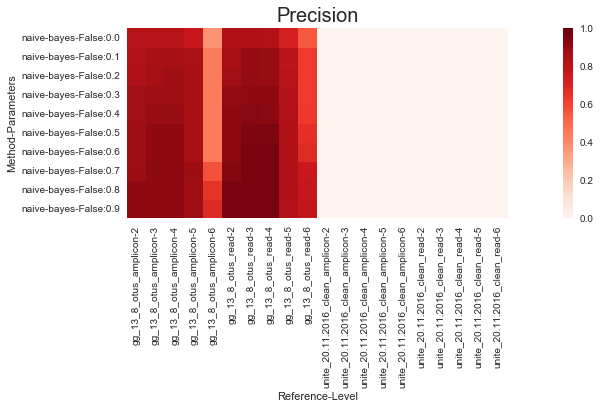

In [20]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

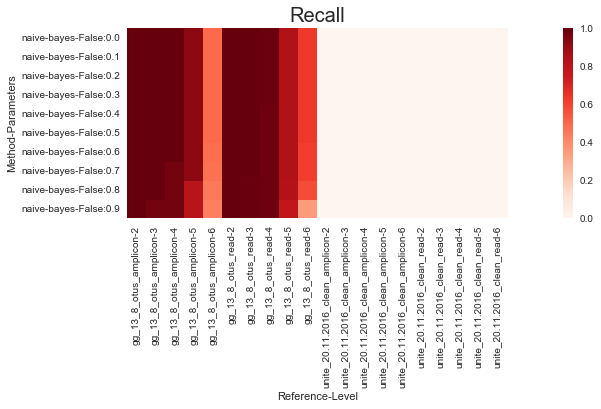

In [21]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

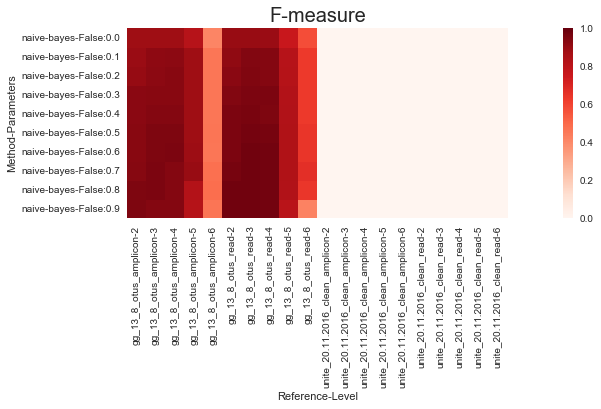

In [22]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

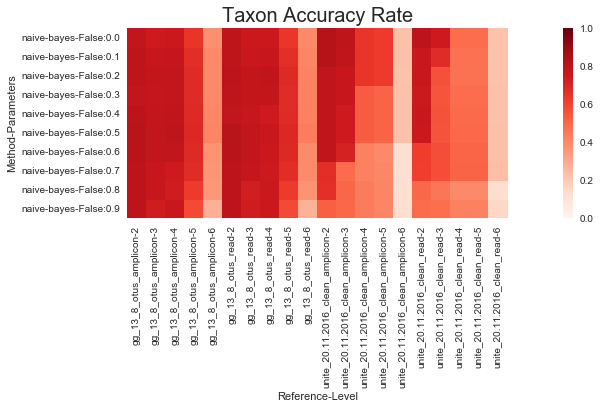

In [23]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

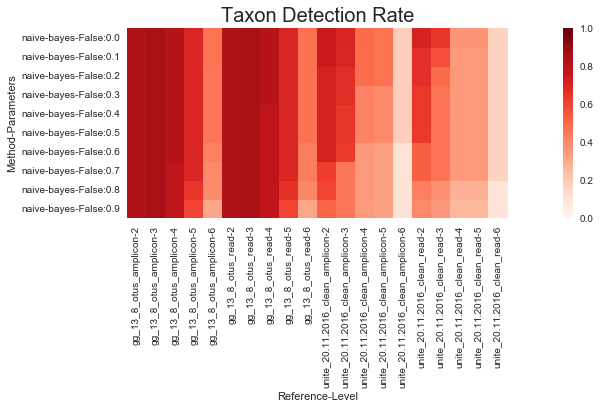

In [24]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at species level (for genus level, change to level 5)

In [25]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

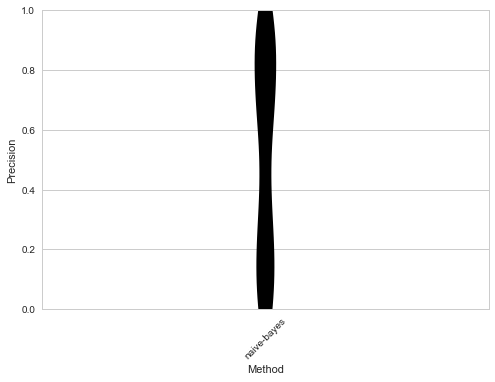

In [26]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

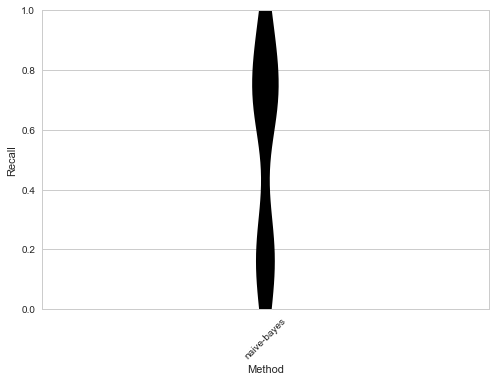

In [27]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

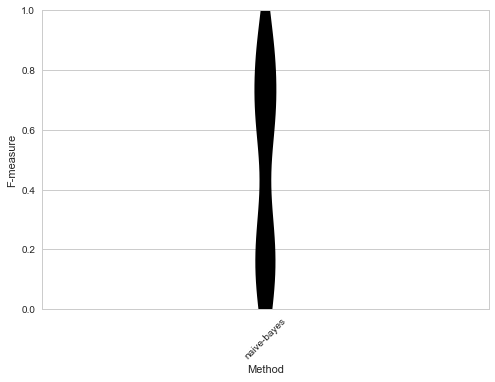

In [28]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

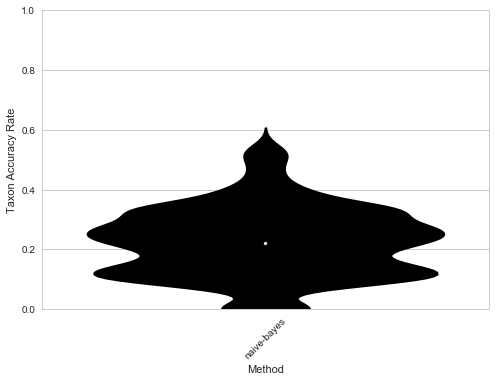

In [29]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Accuracy Rate", color_pallette=color_pallette)

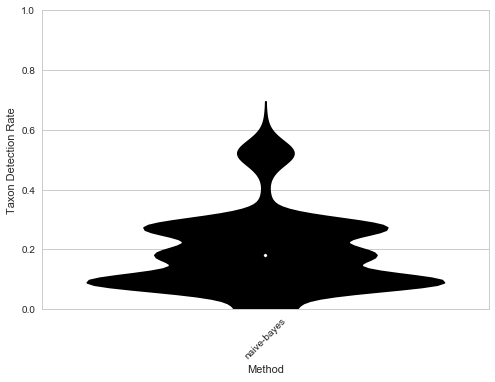

In [30]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Taxon Detection Rate", color_pallette=color_pallette)

In the following heatmaps, we assess accuracy rates in each dataset X method configuration combination. This allows us to assess how evenly configurations affect performance, whether specific mock communities outperform of underperform relative to others, and generally assess how increasing/decreasing specific parameters affects accuracy.

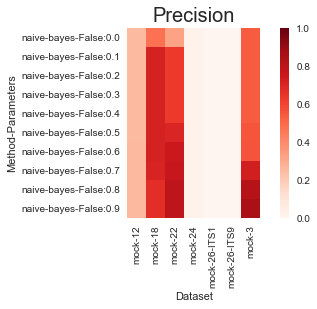

In [31]:
heatmap_from_data_frame(mock_results_6, "Precision")

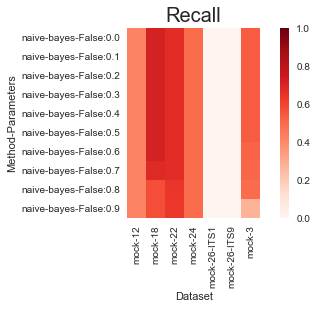

In [32]:
heatmap_from_data_frame(mock_results_6, "Recall")

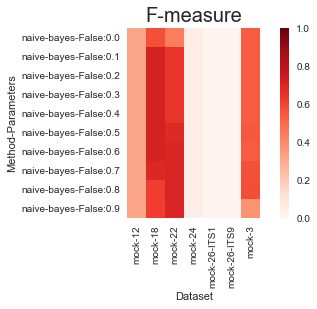

In [33]:
heatmap_from_data_frame(mock_results_6, "F-measure")

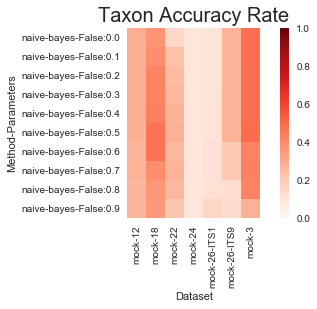

In [34]:
heatmap_from_data_frame(mock_results_6, "Taxon Accuracy Rate")

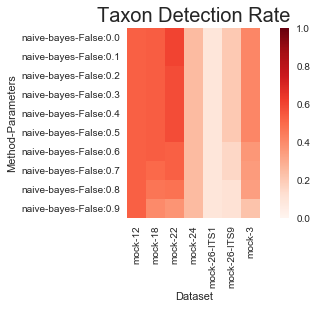

In [35]:
heatmap_from_data_frame(mock_results_6, "Taxon Detection Rate")

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [36]:
for i in [n for n in range(1,27)]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-2

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-3

Method Parameters  Precision    Recall  F-measure  \
2938  naive-bayes  False:0.6   0.948451  0.884082   0.915136   

      Taxon Accuracy Rate  Taxon Detection Rate  
2938             0.384615                  0.25

## mock-4

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-5

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-6

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-7

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-8

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-9

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-10

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-11

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-12

Method Parameters  Precision    Recall  F-measure  \
49  naive-bayes  False:0.9   0.448018  0.760675   0.563908   

    Taxon Accuracy Rate  Taxon Detection Rate  
49             0.268293               0.52381

## mock-13

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-14

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-15

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-16

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-17

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-18

Method Parameters  Precision    Recall  F-measure  \
64  naive-bayes  False:0.2   0.718479  0.719042    0.71876   

    Taxon Accuracy Rate  Taxon Detection Rate  
64             0.421053              0.533333

## mock-19

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-20

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-21

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-22

Method Parameters  Precision    Recall  F-measure  \
139  naive-bayes  False:0.7   0.920041  0.676028   0.779382   

     Taxon Accuracy Rate  Taxon Detection Rate  
139             0.277778              0.526316

## mock-23

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-24

Method Parameters  Precision    Recall  F-measure  \
199  naive-bayes  False:0.9   0.044785  0.991618   0.085699   

     Taxon Accuracy Rate  Taxon Detection Rate  
199             0.181818                   0.5

## mock-25

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

## mock-26

Empty DataFrame
Columns: [Method, Parameters, Precision, Recall, F-measure, Taxon Accuracy Rate, Taxon Detection Rate]
Index: []

Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [37]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Precision', 'Recall', 'F-measure',
                 'Taxon Accuracy Rate', 'Taxon Detection Rate'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:10])

## naive-bayes

F-measure  Precision  Recall  Taxon Accuracy Rate  \
False:0.0        110        108     114                   89   
False:0.1        112        110     114                   89   
False:0.2        112        110     114                   89   
False:0.3        112        110     114                   91   
False:0.4        112        110     114                   92   
False:0.5        113        111     114                   93   
False:0.6        112        112     113                   45   
False:0.7        113        115     112                   44   
False:0.8        111        115     110                    5   
False:0.9        107        115     106                   13   

           Taxon Detection Rate  
False:0.0                   117  
False:0.1                   117  
False:0.2                   117  
False:0.3                   117  
False:0.4                   117  
False:0.5                   117  
False:0.6                    69  
False:0.7                    68  
False:0.8                    27  
False:0.9                    27

## Optimized method performance
And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## gg_13_8_otus level 4

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
1     blast+   0.001:10:0.75:0.99             0.686957              0.887050   
6    vsearch        100:0.51:0.99             0.673609              0.901756   
5     uclust          0.51:0.97:3             0.670833              0.898296   
3        rdp                  0.4             0.664497              0.880995   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.674404              0.906946   
0      blast                1e-10             0.674631              0.906946   
2      q2-nb                  0.8             0.640295              0.851356   

   Precision    Recall  F-measure  
1   0.753998  0.942188   0.820880  
6   0.729464  0.969096   0.799002  
5   0.728687  0.969664   0.797892  
3   0.719361  0.963950   0.789074  
4   0.710674  0.966657   0.786810  
0   0.688628  0.989298   0.780824  
2   0.699799  0.944384   0.763884

Method A   Method B         P
0       blast     blast+  0.548844
1       blast      q2-nb  1.000000
2       blast        rdp  0.998978
3       blast  sortmerna  0.999652
4       blast     uclust  0.935554
5       blast    vsearch  0.935554
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.721033
8      blast+  sortmerna  0.475009
9      blast+     uclust  0.935554
10     blast+    vsearch  0.935554
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.999998
16        rdp     uclust  0.916850
17        rdp    vsearch  0.935554
18  sortmerna     uclust  0.935554
19  sortmerna    vsearch  0.791502
20     uclust    vsearch  0.999998

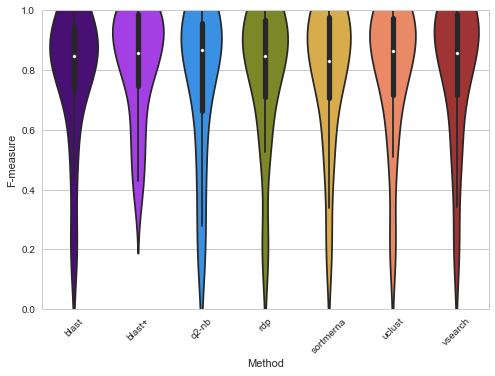

## gg_13_8_otus level 5

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
3        rdp                  0.4             0.595964              0.791798   
1     blast+   0.001:10:0.75:0.99             0.556674              0.672949   
6    vsearch        100:0.51:0.99             0.524026              0.677256   
5     uclust          0.51:0.99:5             0.537931              0.685772   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.533477              0.699714   
0      blast                1e-10             0.549269              0.724974   
2      q2-nb                  0.8             0.497620              0.630311   

   Precision    Recall  F-measure  
3   0.680328  0.880687   0.733048  
1   0.701210  0.788116   0.727109  
6   0.652424  0.824075   0.697099  
5   0.647502  0.812062   0.687733  
4   0.608094  0.829165   0.671879  
0   0.593849  0.844151   0.667888  
2   0.628016  0.781604   0.652434

Method A   Method B         P
0       blast     blast+  0.057762
1       blast      q2-nb  1.000000
2       blast        rdp  0.008238
3       blast  sortmerna  0.999999
4       blast     uclust  0.678472
5       blast    vsearch  0.388718
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.999997
8      blast+  sortmerna  0.457546
9      blast+     uclust  0.288530
10     blast+    vsearch  0.513041
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.210622
16        rdp     uclust  0.026076
17        rdp    vsearch  0.354562
18  sortmerna     uclust  0.996537
19  sortmerna    vsearch  0.954782
20     uclust    vsearch  0.776930

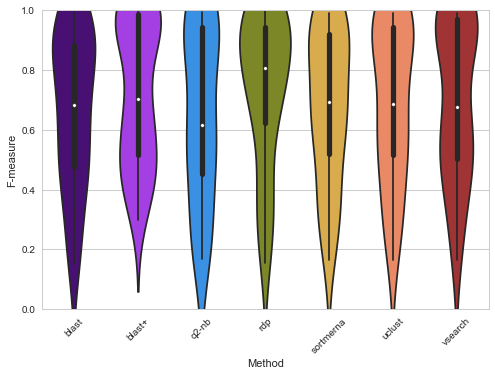

## gg_13_8_otus level 6

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch           1:0.51:0.9             0.464563              0.544289   
5     uclust           0.51:0.9:5             0.395616              0.463674   
3        rdp                  0.3             0.421973              0.555281   
1     blast+  0.001:100:0.75:0.99             0.363413              0.411505   
0      blast                1e-10             0.455796              0.550526   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.440423              0.514265   
2      q2-nb                  0.0             0.385413              0.429105   

   Precision    Recall  F-measure  
6   0.463164  0.632890   0.515258  
5   0.476240  0.612941   0.508065  
3   0.465344  0.600198   0.503711  
1   0.545393  0.509649   0.503425  
0   0.441500  0.622074   0.498186  
4   0.447001  0.595190   0.491202  
2   0.332961  0.500667   0.374824

Method A   Method B         P
0       blast     blast+  1.000000
1       blast      q2-nb  1.000000
2       blast        rdp  1.000000
3       blast  sortmerna  1.000000
4       blast     uclust  1.000000
5       blast    vsearch  0.999261
6      blast+      q2-nb  1.000000
7      blast+        rdp  1.000000
8      blast+  sortmerna  0.999986
9      blast+     uclust  1.000000
10     blast+    vsearch  1.000000
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  1.000000
17        rdp    vsearch  1.000000
18  sortmerna     uclust  0.999991
19  sortmerna    vsearch  0.994262
20     uclust    vsearch  1.000000

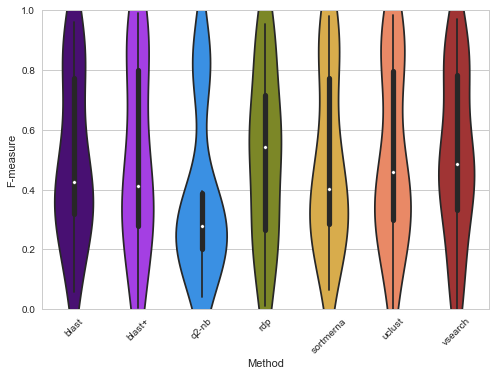

## unite_20.11.2016_clean_fullITS level 4

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch         10:0.99:0.99             0.832841              0.498162   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.872001              0.536633   
1     blast+    0.001:1:0.99:0.99             0.863462              0.534183   
5     uclust            1.0:0.9:1             0.827248              0.529405   
0      blast                 1000             0.877336              0.569346   
2      q2-nb                  0.0             0.673077              1.000000   
3        rdp                  1.0             0.830186              0.551619   

   Precision    Recall  F-measure  
6   0.626310  0.915205   0.706503  
4   0.570488  0.892229   0.660916  
1   0.562234  0.902586   0.654177  
5   0.543525  0.900079   0.639951  
0   0.518953  0.910361   0.622397  
2   0.264531  0.717199   0.382224  
3   0.054671  0.258453   0.101851

Method A   Method B         P
0       blast     blast+  0.007682
1       blast      q2-nb  1.000000
2       blast        rdp  1.000000
3       blast  sortmerna  0.005964
4       blast     uclust  0.417521
5       blast    vsearch  0.000010
6      blast+      q2-nb  1.000000
7      blast+        rdp  1.000000
8      blast+  sortmerna  0.999954
9      blast+     uclust  0.974809
10     blast+    vsearch  0.004702
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  1.000000
17        rdp    vsearch  1.000000
18  sortmerna     uclust  0.815608
19  sortmerna    vsearch  0.008251
20     uclust    vsearch  0.000059

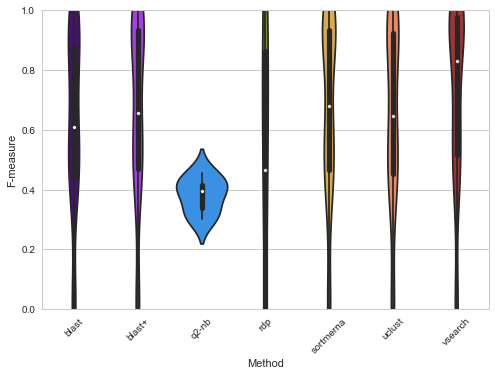

## unite_20.11.2016_clean_fullITS level 5

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch        100:0.99:0.99             0.819110              0.485921   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.859666              0.528659   
1     blast+    0.001:1:0.99:0.99             0.851639              0.537402   
5     uclust            1.0:0.9:1             0.810428              0.513007   
0      blast                 1000             0.855505              0.557104   
2      q2-nb                  0.0             0.482251              0.666667   
3        rdp                  1.0             0.823312              0.545215   

   Precision    Recall  F-measure  
6   0.624021  0.908351   0.702998  
4   0.570488  0.892229   0.660916  
1   0.562234  0.902586   0.654177  
5   0.539798  0.892547   0.635036  
0   0.516097  0.902829   0.618294  
2   0.170069  0.463047   0.246457  
3   0.079278  0.258453   0.107944

Method A   Method B         P
0       blast     blast+  0.003523
1       blast      q2-nb  1.000000
2       blast        rdp  1.000000
3       blast  sortmerna  0.000941
4       blast     uclust  0.508487
5       blast    vsearch  0.000010
6      blast+      q2-nb  1.000000
7      blast+        rdp  1.000000
8      blast+  sortmerna  0.999954
9      blast+     uclust  0.862536
10     blast+    vsearch  0.017500
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  1.000000
17        rdp    vsearch  1.000000
18  sortmerna     uclust  0.519191
19  sortmerna    vsearch  0.021511
20     uclust    vsearch  0.000052

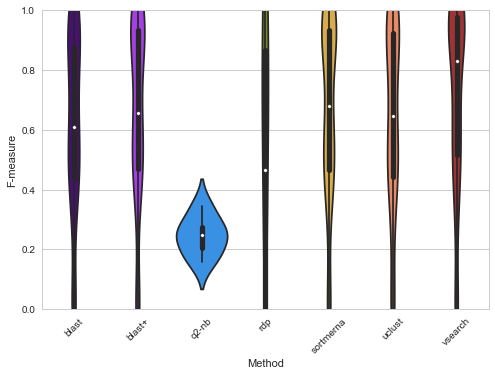

## unite_20.11.2016_clean_fullITS level 6

Method          Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch        10:0.99:0.99             0.634947              0.402015   
4  sortmerna  1.0:0.99:5:0.9:1.0             0.656102              0.442860   
1     blast+   0.001:1:0.99:0.99             0.654569              0.441467   
0      blast                1000             0.611874              0.419597   
5     uclust          0.76:0.9:1             0.472961              0.331904   
2      q2-nb                 0.0             0.207296              0.250000   
3        rdp                 0.9             0.664189              0.481444   

   Precision    Recall  F-measure  
6   0.634510  0.873905   0.707028  
4   0.618356  0.885771   0.692788  
1   0.546366  0.873905   0.633799  
0   0.454307  0.800586   0.545847  
5   0.451409  0.756085   0.533303  
2   0.103370  0.288393   0.150212  
3   0.037583  0.257951   0.097600

Method A   Method B             P
0       blast     blast+  9.924214e-05
1       blast      q2-nb  1.000000e+00
2       blast        rdp  1.000000e+00
3       blast  sortmerna  3.628813e-09
4       blast     uclust  9.959991e-01
5       blast    vsearch  4.294145e-08
6      blast+      q2-nb  1.000000e+00
7      blast+        rdp  1.000000e+00
8      blast+  sortmerna  1.181807e-04
9      blast+     uclust  2.006189e-04
10     blast+    vsearch  3.642124e-04
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.000000e+00
16        rdp     uclust  1.000000e+00
17        rdp    vsearch  1.000000e+00
18  sortmerna     uclust  1.899351e-08
19  sortmerna    vsearch  9.977650e-01
20     uclust    vsearch  1.802178e-09

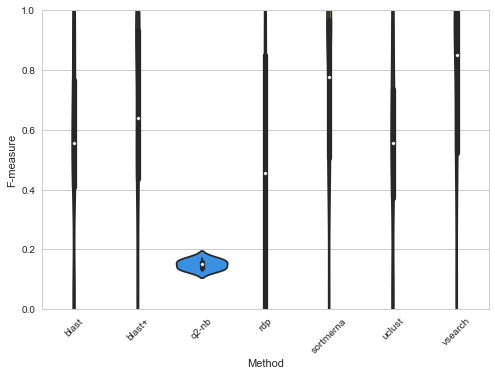

In [16]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="F-measure",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## gg_13_8_otus level 6

Method           Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
6    vsearch          1:0.99:0.99             0.542722              0.575733   
5     uclust           0.76:0.9:1             0.532029              0.572451   
1     blast+    0.001:1:0.99:0.99             0.525470              0.575289   
0      blast                 1000             0.522422              0.577389   
4  sortmerna  0.51:0.99:1:0.9:1.0             0.505285              0.541901   
3        rdp                  0.4             0.497297              0.594122   
2      q2-nb                  0.0             0.470809              0.456071   

   Precision    Recall  F-measure  
6   0.544390  0.686703   0.597835  
5   0.502874  0.616119   0.543603  
1   0.524096  0.655146   0.572972  
0   0.502048  0.657571   0.561059  
4   0.513621  0.637801   0.559756  
3   0.549934  0.649047   0.583304  
2   0.402621  0.508971   0.443730

Method A   Method B         P
0       blast     blast+  0.999000
1       blast      q2-nb  1.000000
2       blast        rdp  0.884502
3       blast  sortmerna  0.178951
4       blast     uclust  0.998062
5       blast    vsearch  0.186639
6      blast+      q2-nb  1.000000
7      blast+        rdp  0.884502
8      blast+  sortmerna  0.004618
9      blast+     uclust  0.999700
10     blast+    vsearch  0.351297
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  0.999700
16        rdp     uclust  0.390044
17        rdp    vsearch  0.110384
18  sortmerna     uclust  0.390044
19  sortmerna    vsearch  0.000438
20     uclust    vsearch  0.950157

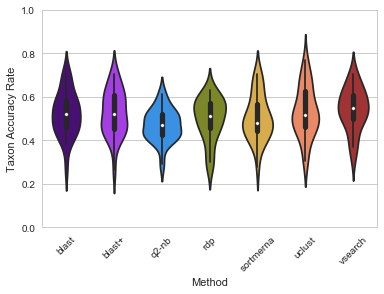

## unite_20.11.2016_clean_fullITS level 6

Method          Parameters  Taxon Accuracy Rate  Taxon Detection Rate  \
4  sortmerna  1.0:0.99:5:0.9:1.0             0.656102              0.442860   
3        rdp                 0.3             0.656101              0.456690   
1     blast+   0.001:1:0.99:0.99             0.654569              0.441467   
6    vsearch          1:0.75:0.9             0.654532              0.453473   
0      blast                1000             0.611874              0.419597   
5     uclust           1.0:0.9:1             0.472961              0.331904   
2      q2-nb                 0.8             0.222222              0.166667   

   Precision    Recall  F-measure  
4   0.618356  0.885771   0.692788  
3   0.509617  0.886089   0.608987  
1   0.546366  0.873905   0.633799  
6   0.510355  0.886089   0.609529  
0   0.454307  0.800586   0.545847  
5   0.451409  0.756085   0.533303  
2   0.088675  0.106742   0.092683

Method A   Method B             P
0       blast     blast+  1.074044e-05
1       blast      q2-nb  1.000000e+00
2       blast        rdp  3.333867e-11
3       blast  sortmerna  5.489092e-07
4       blast     uclust  0.000000e+00
5       blast    vsearch  1.331385e-10
6      blast+      q2-nb  1.000000e+00
7      blast+        rdp  9.999988e-01
8      blast+  sortmerna  9.999930e-01
9      blast+     uclust  0.000000e+00
10     blast+    vsearch  1.000000e+00
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.000000e+00
16        rdp     uclust  0.000000e+00
17        rdp    vsearch  8.522648e-01
18  sortmerna     uclust  0.000000e+00
19  sortmerna    vsearch  9.999984e-01
20     uclust    vsearch  0.000000e+00

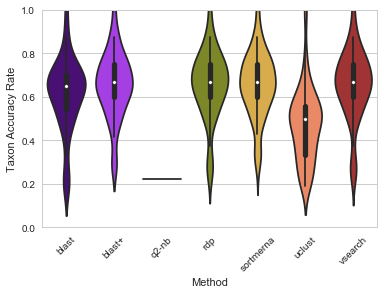

In [194]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="Taxon Accuracy Rate",
                                             level_range=range(6,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Taxon Accuracy Rate",
                                                             "Taxon Detection Rate",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

## Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

__*Note: if you have added additional methods and are attempting to recompute results, set force=True.*__


In [ ]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, force=False)

Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

__*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, make sure you are viewing this notebook in [nbviewer](http://nbviewer.jupyter.org/). (if viewing on GitHub, just copy the URL and paste into the search bar in nbviewer.)*__

In [195]:
table = join(expected_results_dir, 'mock-18', 'gg_13_8_otus', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

R =  0.107665960452 ; P =  0.02


/Users/nbokulich/miniconda3/envs/q2-test/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.425058725719815 and the largest is 4.417440878355716.
  RuntimeWarning


Loading BokehJS ...

You can also view all beta diversity plots with a single command, ``batch_beta_diversity()``, but we will only show single dataset examples in these example notebooks.

### Average dissimilarity between expected results and observed results for each method 


As we already discussed, PCoA plots are good for a qualitative overview, but don't offer much in the way of quantitative comparison. Instead, we can directly compare the Bray-Curtis dissimilarity between methods, and utilize pairwise Mann-Whitney U tests to determine precisely which methods perform better (**lower dissimilarity = more accurate classification**). In the cell below, we will use distance comparisons to determine:

    1) Whether the dissimilarity between taxonomic assignment with different parameters of the same method is greater or less than the dissimilarity between taxonomic assignments with different methods, including the expected composition.
    2) which method (averaged across all configurations) most closely reproduces the expected composition.
    
You can generate boxplots for individual datasets one-by-one with ``per_method_boxplots()``, or for all datasets individually with ``fastlane_boxplots()``. However, here we are most interested in the average performance of methods across each dataset.

The command below violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

## gg_13_8_otus

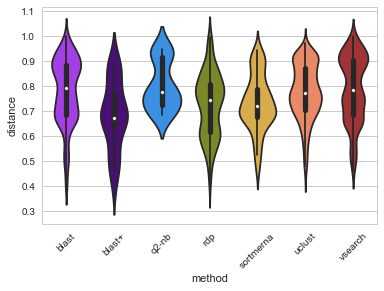

method A   method B             P
0      blast+      blast  4.613902e-06
1      blast+      q2-nb  7.597099e-01
2      blast+        rdp  1.509068e-08
3      blast+  sortmerna  1.270810e-05
4      blast+     uclust  8.736689e-01
5      blast+    vsearch  7.519476e-01
6       blast      q2-nb  1.313426e-04
7       blast        rdp  2.478060e-01
8       blast  sortmerna  7.161906e-02
9       blast     uclust  1.421662e-07
10      blast    vsearch  6.293324e-07
11      q2-nb        rdp  2.729586e-03
12      q2-nb  sortmerna  2.729586e-03
13      q2-nb     uclust  6.607385e-01
14      q2-nb    vsearch  8.736689e-01
15        rdp  sortmerna  8.736689e-01
16        rdp     uclust  1.287590e-09
17        rdp    vsearch  1.779610e-11
18  sortmerna     uclust  2.166953e-06
19  sortmerna    vsearch  1.845250e-07
20     uclust    vsearch  4.496220e-01

## unite_20.11.2016_clean_fullITS

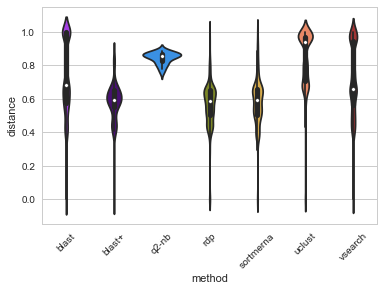

method A   method B         P
0      blast+      blast  0.000000
1      blast+      q2-nb  0.013377
2      blast+        rdp  0.000000
3      blast+  sortmerna  0.000000
4      blast+     uclust  0.000000
5      blast+    vsearch  0.642323
6       blast      q2-nb  0.000000
7       blast        rdp  0.658687
8       blast  sortmerna  0.737130
9       blast     uclust  0.000000
10      blast    vsearch  0.000000
11      q2-nb        rdp  0.000000
12      q2-nb  sortmerna  0.000000
13      q2-nb     uclust  0.794764
14      q2-nb    vsearch  0.005153
15        rdp  sortmerna  0.021680
16        rdp     uclust  0.000000
17        rdp    vsearch  0.000000
18  sortmerna     uclust  0.000000
19  sortmerna    vsearch  0.000000
20     uclust    vsearch  0.000000

None

In [196]:
results = average_distance_boxplots(expected_results_dir, paired=False,
                                    use_best=False, color_pallette=color_pallette)
display(results)

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

## gg_13_8_otus

method               params
0     blast+     0.001:1:0.99:0.8
1      blast                 1000
2      q2-nb                  0.0
3        rdp                  0.3
4  sortmerna  0.51:0.99:1:0.9:1.0
5     uclust           0.76:0.9:1
6    vsearch          1:0.99:0.99

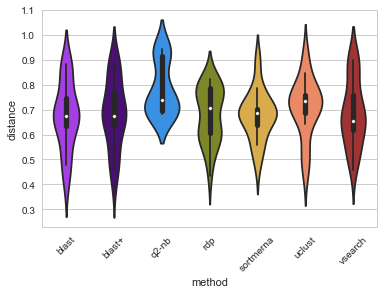

method A   method B         P
0      blast+      blast  0.288080
1      blast+      q2-nb  1.000000
2      blast+        rdp  1.000000
3      blast+  sortmerna  1.000000
4      blast+     uclust  0.431959
5      blast+    vsearch  0.836601
6       blast      q2-nb  1.000000
7       blast        rdp  0.999999
8       blast  sortmerna  0.999999
9       blast     uclust  0.754548
10      blast    vsearch  0.999999
11      q2-nb        rdp  1.000000
12      q2-nb  sortmerna  1.000000
13      q2-nb     uclust  1.000000
14      q2-nb    vsearch  1.000000
15        rdp  sortmerna  1.000000
16        rdp     uclust  0.596355
17        rdp    vsearch  0.999998
18  sortmerna     uclust  0.480903
19  sortmerna    vsearch  0.999998
20     uclust    vsearch  0.762150

## unite_20.11.2016_clean_fullITS

method              params
0     blast+   0.001:1:0.99:0.99
1      blast                1000
2      q2-nb                 0.0
3        rdp                 0.3
4  sortmerna  1.0:0.99:5:0.9:1.0
5     uclust           1.0:0.9:1
6    vsearch         1:0.99:0.99

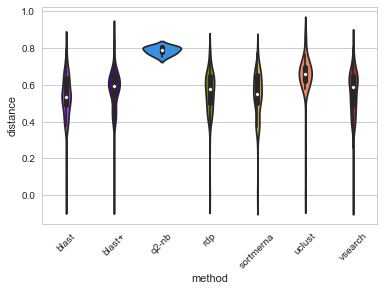

method A   method B             P
0      blast+      blast  0.000000e+00
1      blast+      q2-nb  1.000000e+00
2      blast+        rdp  0.000000e+00
3      blast+  sortmerna  3.057254e-02
4      blast+     uclust  0.000000e+00
5      blast+    vsearch  4.109293e-07
6       blast      q2-nb  1.000000e+00
7       blast        rdp  3.491831e-07
8       blast  sortmerna  4.263256e-14
9       blast     uclust  2.275840e-10
10      blast    vsearch  3.768143e-08
11      q2-nb        rdp  1.000000e+00
12      q2-nb  sortmerna  1.000000e+00
13      q2-nb     uclust  1.000000e+00
14      q2-nb    vsearch  1.000000e+00
15        rdp  sortmerna  1.676176e-05
16        rdp     uclust  1.998401e-15
17        rdp    vsearch  8.844002e-02
18  sortmerna     uclust  3.019807e-14
19  sortmerna    vsearch  5.078448e-03
20     uclust    vsearch  4.996004e-14

In [198]:
results = average_distance_boxplots(expected_results_dir,
                                    color_pallette=color_pallette)
results